In [1]:
#load the data
import datetime
import pandas as pd
import numpy as np
import cPickle as pickle
from sklearn.cross_validation import train_test_split

# Part 1: Load the cleaned Data

In [2]:
# loading data from the pickled data frame

with open('master_total_df.p','rb') as f:
    master_total_df = pickle.load(f)

### Isolating data that actually has view information
Isolating datasource 2 - that has all the viewing data information. Unfortunately since it took too long to scrape, there's only 8k records to use of the overall 22k. 

In [3]:
print master_total_df.shape
# only one data source has view data, will sub-set here.
jobview_data = master_total_df[master_total_df.sourcesite =='lnk'].copy()
print jobview_data.shape
jobview_data.reset_index(inplace=True)
jobview_data.head(5)

(22707, 15)
(8038, 15)


,level_0,index,company,jobdesc,city,state,title,sourcesite,views,days_posted,post_start_date,base_title,parsed_title,parsed_title_i,expanded_title,prefix_title
0,14669,0,Jobspring Partners,Python/SQL Analyst\n\nData Analysts capable of...,Chicago,IL,Python/SQL Analyst,lnk,0,Posted 28 days ago,"August 23, 2016",analyst,"[python, sql, analyst]",[2],sql analyst,sql
1,14670,1,Broad Institute,The Broad Institute of Harvard and MIT is look...,Cambridge,MA,Senior Associate Computational Biologist,lnk,52,Posted 13 days ago,"September 8, 2016",associate,"[senior, associate, computational, biologist]",[1],senior associate,senior
2,14671,2,Stripe,Stripe’s people are its most valuable resource...,San Francisco,CA,Compensation Analyst,lnk,83,Posted 9 days ago,"September 12, 2016",analyst,"[compensation, analyst]",[1],compensation analyst,compensation
3,14672,3,Facebook,Facebook was built to help people connect and ...,Seattle - -,WA,"Data Engineer, Analytics - Seattle",lnk,1893,Posted 9 days ago,"September 12, 2016",engineer,"[data, engineer, , analytics, , , seattle]",[1],data engineer,data
4,14673,4,UnitedHealth Group,Description\n\nYou believe data can help resha...,Minnetonka,MN,"Senior Business Analyst - Minnetonka, MN",lnk,0,Posted 2 days ago,"September 19, 2016",analyst,"[senior, business, analyst, , , minnetonka, , mn]",[2],business analyst,business


# Part 2: Doing the EDA for the views column
### Views: Is it even populated?

For the data that has fields for views and counts, find out how many of the rows are actually populated with numbers

In [4]:
print jobview_data.info()
jobview_data['views'].describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8038 entries, 0 to 8037
Data columns (total 16 columns):
level_0            8038 non-null int64
index              8038 non-null int64
company            8038 non-null object
jobdesc            8038 non-null object
city               8038 non-null object
state              6145 non-null object
title              8038 non-null object
sourcesite         8038 non-null object
views              8038 non-null int64
days_posted        8038 non-null object
post_start_date    8038 non-null object
base_title         8038 non-null object
parsed_title       8038 non-null object
parsed_title_i     8038 non-null object
expanded_title     7510 non-null object
prefix_title       7510 non-null object
dtypes: int64(3), object(13)
memory usage: 1004.8+ KB
None


count    8038.000000
mean      122.009579
std       373.737292
min         0.000000
25%         0.000000
50%         0.000000
75%        98.000000
max      7696.000000
Name: views, dtype: float64

Filling in the blank fields with either "other" or replacing some of the " " with "blanks"

In [5]:
jobview_data['expanded_title'].fillna('other',inplace=True)
jobview_data['prefix_title'].fillna('other',inplace=True)
jobview_data['state'].fillna('other',inplace=True)
jobview_data['base_title'].replace(to_replace='', value='other',inplace=True)

Plotting views that are below less than 10,000 views, excluding outliers 

(array([ 398.,    0.,  132.,    0.,    0.,   61.,    0.,   47.,    0.,
           0.,   46.,    0.,   26.,    0.,    0.,   29.,    0.,   21.,
           0.,    0.,   17.,    0.,   16.,    0.,    0.,   23.,    0.,
          15.,    0.,    0.,    9.,    0.,    8.,    0.,    0.,    8.,
           0.,    6.,    0.,    0.,    3.,    0.,    1.,    0.,    0.,
           3.,    0.,    1.,    0.,    2.]),
 array([  1. ,   1.4,   1.8,   2.2,   2.6,   3. ,   3.4,   3.8,   4.2,
          4.6,   5. ,   5.4,   5.8,   6.2,   6.6,   7. ,   7.4,   7.8,
          8.2,   8.6,   9. ,   9.4,   9.8,  10.2,  10.6,  11. ,  11.4,
         11.8,  12.2,  12.6,  13. ,  13.4,  13.8,  14.2,  14.6,  15. ,
         15.4,  15.8,  16.2,  16.6,  17. ,  17.4,  17.8,  18.2,  18.6,
         19. ,  19.4,  19.8,  20.2,  20.6,  21. ]),
 <a list of 50 Patch objects>)

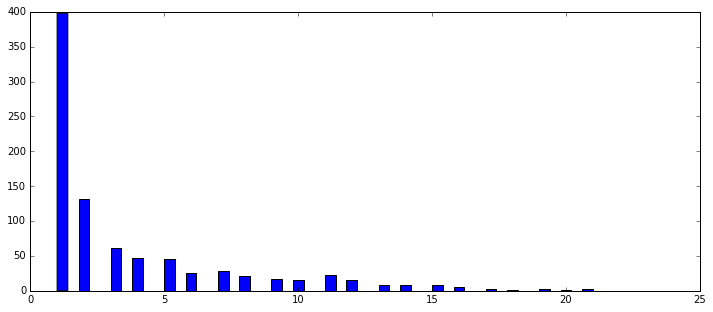

In [6]:

import matplotlib.pyplot as plt
% matplotlib inline
summary = jobview_data['views'].value_counts()
fig, ax = plt.subplots(figsize=(12,5))
ax.hist(summary[summary<1000], bins=50)

# How many lines have view counts?

In [7]:
# how many have views
summary[summary.index>=1].sum()

3169

# How many lines don't have view counts?

In [8]:
# how many don't
summary[summary.index==0].sum()

4869

# Part 3: Feature selection and additional Features

### Features that will be used

- City
- State
- Posting start date
- Days up
- Length of Job description
- Company
- Position name (generic)
- Semi-specific Position Name
- Posting Month (start)

Even though these are only a few features, because they are categorical, this will turn into a large number of features. For example: "Apple", "IBM","Amazon" listings in the "COMPANY" field will result in 2-3 new features. For 8000 job postings, this will increase to be much larger.

If these features are not enough, word analysis will be performed to see if certain words will result in more views of the paragraphs. Will clean the date first.

In [9]:
# prototyping 
from datetime import datetime
date_object = datetime.strptime('Jun 1 2005  1:33PM', '%b %d %Y %I:%M%p')
date_object = datetime.strptime('August 23, 2016', '%B %d, %Y')
print date_object

#jobview_data['post_start_date'] = jobview_data['post_start_date'].map(lambda x : datetime.strptime(x, '%B %d, %Y'))
jobview_data['post_month'] = jobview_data['post_start_date'].map(lambda x : x[:3] )


jobview_data['days_posted'] = jobview_data['days_posted'].map(lambda x: x.split(' ')[1])
jobview_data['description_length'] = jobview_data['jobdesc'].map(lambda x: len(x))

2016-08-23 00:00:00


In [10]:
jobview_data.head(1)

,level_0,index,company,jobdesc,city,state,title,sourcesite,views,days_posted,post_start_date,base_title,parsed_title,parsed_title_i,expanded_title,prefix_title,post_month,description_length
0,14669,0,Jobspring Partners,Python/SQL Analyst\n\nData Analysts capable of...,Chicago,IL,Python/SQL Analyst,lnk,0,28,"August 23, 2016",analyst,"[python, sql, analyst]",[2],sql analyst,sql,Aug,1100


# Create word features from job description - top 50,000 repeated words 

In [11]:
# uni-decoding the data in the job descriptions. Replacing the \n for spaces. THe reason for this is 
# we are not doing sentence splitting or separation, so splaces should suffice to split the words

import unidecode
text = jobview_data['jobdesc'].map(lambda x : unidecode.unidecode(x).replace('\n',' '))

In [12]:
# examine a few of the samples
text[:4]

0    Python/SQL Analyst  Data Analysts capable of w...
1    The Broad Institute of Harvard and MIT is look...
2    Stripe's people are its most valuable resource...
3    Facebook was built to help people connect and ...
Name: jobdesc, dtype: object

In [13]:
# splitting the job descriptions by words using count vectorizer
# this will be done separately then merged together with the other remaining fields
# one note: there will most likely be duplicate word fields for 
# company views and date (since these are not considered common stop words)
# using count vectorizer for this particular assessment
# also added time counters to determine the run time

from sklearn.feature_extraction.text import CountVectorizer
cvec = CountVectorizer(stop_words='english', lowercase=True,ngram_range=(1,1))
start_time = datetime.now()
cvec.fit(text)
print datetime.now() - start_time

cdf  = pd.DataFrame(cvec.transform(text).todense(),
             columns=cvec.get_feature_names())
print datetime.now() - start_time
print cdf.shape
cdf.head(4)

0:00:04.558753
0:00:10.560918
(8038, 40752)


,00,000,00004,0001727,0001731,0008829007,0008837538,000k,000s,001,...,zuora,zurb,zurich,zurichrisk,zyme,zymergen,zymeworks,zynga,zynq,zypper
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [14]:
# check the vocabulary to see if any of the word splitting has worked in correctly
# there are a few postings that have space 
cvec.vocabulary_

{u'nordisk': 24674,
 u'first5sf': 15234,
 u'resourcesexperienced': 31173,
 u'circuitry': 7517,
 u'netcdf': 24367,
 u'spiders': 34656,
 u'hanging': 17086,
 u'localized': 21549,
 u'reallocations': 30025,
 u'chatter': 7350,
 u'simultaneouslydemonstrable': 33562,
 u'scole': 32533,
 u'functioncreative': 15931,
 u'agreementsunderstanding': 2926,
 u'unnecessarily': 38725,
 u'xunit': 40549,
 u'evangelical': 13842,
 u'solutionsproficient': 34274,
 u'initiativesbecome': 18899,
 u'tableaucomfort': 36287,
 u'replaces': 30658,
 u'teamstranslation': 36739,
 u'bringing': 6134,
 u'receiving': 30086,
 u'liaisons': 21220,
 u'grains': 16667,
 u'wednesday': 39945,
 u'roleelicit': 31797,
 u'analysiseffectively': 3413,
 u'driveexperience': 12217,
 u'projectsexcellent': 28963,
 u'segmentsupporting': 32815,
 u'bbqs': 5286,
 u'9exp': 2044,
 u'titlesr': 37538,
 u'2421227': 933,
 u'scraper': 32574,
 u'feasibility': 14850,
 u'designability': 10997,
 u'275': 992,
 u'276': 994,
 u'277': 995,
 u'279': 996,
 u'inanim

In [15]:
start_time = datetime.now()
summary = cdf.sum().sort_values(ascending=False)
print datetime.now() - start_time

0:00:06.712314


In [16]:
word_features = summary[:10000].index
word_features

cdf_for_merge = cdf[word_features].copy()
cdf_for_merge.columns = ['nlp_'+x for x in cdf_for_merge.columns]
cdf_for_merge.head()

,nlp_data,nlp_experience,nlp_business,nlp_work,nlp_team,nlp_skills,nlp_management,nlp_development,nlp_years,nlp_ability,...,nlp_sba,nlp_studied,nlp_manchester,nlp_bhe,nlp_mangers,nlp_computationally,nlp_comprise,nlp_threatening,nlp_cmms,nlp_beachbody
0,10,1,1,1,2,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,8,7,0,1,3,0,0,0,2,4,...,0,0,0,0,0,0,0,0,0,0
2,1,4,1,5,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,16,8,1,3,1,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0
4,5,11,8,3,3,1,2,0,4,1,...,0,0,0,0,0,0,0,0,0,0


In [17]:
job_columns = ['company','city','state','views','days_posted','base_title','expanded_title', 'post_month','description_length']
jobview_data.head(2)

,level_0,index,company,jobdesc,city,state,title,sourcesite,views,days_posted,post_start_date,base_title,parsed_title,parsed_title_i,expanded_title,prefix_title,post_month,description_length
0,14669,0,Jobspring Partners,Python/SQL Analyst\n\nData Analysts capable of...,Chicago,IL,Python/SQL Analyst,lnk,0,28,"August 23, 2016",analyst,"[python, sql, analyst]",[2],sql analyst,sql,Aug,1100
1,14670,1,Broad Institute,The Broad Institute of Harvard and MIT is look...,Cambridge,MA,Senior Associate Computational Biologist,lnk,52,13,"September 8, 2016",associate,"[senior, associate, computational, biologist]",[1],senior associate,senior,Sep,2794


# merge the word features with main table

In [18]:
jobview_data_plus = jobview_data[job_columns].merge(cdf_for_merge, how='left', left_index=True, right_index=True)
jobview_data_plus.head()

,company,city,state,views,days_posted,base_title,expanded_title,post_month,description_length,nlp_data,...,nlp_sba,nlp_studied,nlp_manchester,nlp_bhe,nlp_mangers,nlp_computationally,nlp_comprise,nlp_threatening,nlp_cmms,nlp_beachbody
0,Jobspring Partners,Chicago,IL,0,28,analyst,sql analyst,Aug,1100,10,...,0,0,0,0,0,0,0,0,0,0
1,Broad Institute,Cambridge,MA,52,13,associate,senior associate,Sep,2794,8,...,0,0,0,0,0,0,0,0,0,0
2,Stripe,San Francisco,CA,83,9,analyst,compensation analyst,Sep,1897,1,...,0,0,0,0,0,0,0,0,0,0
3,Facebook,Seattle - -,WA,1893,9,engineer,data engineer,Sep,2961,16,...,0,0,0,0,0,0,0,0,0,0
4,UnitedHealth Group,Minnetonka,MN,0,2,analyst,business analyst,Sep,4277,5,...,0,0,0,0,0,0,0,0,0,0


In [19]:
jobview_data[job_columns].head(4)

,company,city,state,views,days_posted,base_title,expanded_title,post_month,description_length
0,Jobspring Partners,Chicago,IL,0,28,analyst,sql analyst,Aug,1100
1,Broad Institute,Cambridge,MA,52,13,associate,senior associate,Sep,2794
2,Stripe,San Francisco,CA,83,9,analyst,compensation analyst,Sep,1897
3,Facebook,Seattle - -,WA,1893,9,engineer,data engineer,Sep,2961


## Normalize the data for regularization

In [20]:
from sklearn.preprocessing import StandardScaler

# initialize the scaler and create a normalized dataset
sclr = StandardScaler()
jobview_data_norm = jobview_data.copy()

# convert to float and remove any words in the column
jobview_data_norm['days_posted'].replace(to_replace=unicode('less'), value=0. , inplace=True)
jobview_data_norm['days_posted'] = jobview_data_norm['days_posted'].astype(float)

jobview_data_norm['description_length'].replace(to_replace='less', value=0. , inplace=True)
jobview_data_norm['description_length'] = jobview_data_norm['description_length'].astype(float)


# normalize the two number features
norm_cols = ['days_posted','description_length']
jobview_data_norm[norm_cols].mean()
jobview_data_norm[norm_cols] = sclr.fit_transform(jobview_data_norm[norm_cols])


In [21]:
jobview_data[['days_posted','description_length','views']].corr()

,description_length,views
description_length,1.000000,-0.030194
views,-0.030194,1.000000


# Patsy for modeling

In [22]:
import patsy



In [23]:
unicode('less')

u'less'

In [24]:

formula = 'views ~ ' + ' + '.join([x for x in jobview_data_norm[job_columns].columns if x != 'views']) + '-1'
y, X = patsy.dmatrices(formula, jobview_data_norm,return_type='dataframe')
#X = X.merge(cdf_for_merge, how='left', left_index=True, right_index=True)

y = np.ravel(y)
print X.shape, y.shape

(8038, 4047) (8038,)


In [25]:
y[:10]

array([    0.,    52.,    83.,  1893.,     0.,   458.,   124.,     0.,
         314.,     2.])

In [26]:
print X.shape
X.head()

(8038, 4047)


,"company[1-800-FLOWERS.COM, INC.]",company[1010data],"company[10th Magnitude, Inc.]",company[1871],"company[22nd Century Staffing, Inc.]",company[23andMe],company[24 Seven Inc.],company[2Modern],company[2U],"company[3 Key Consulting, Inc.]",...,expanded_title[T.writer consultant],post_month[T.Aug],post_month[T.Feb],post_month[T.Jul],post_month[T.Jun],post_month[T.Mar],post_month[T.May],post_month[T.Sep],days_posted,description_length
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.911047,-1.268119
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.128718,-0.251947
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.405989,-0.790026
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.405989,-0.151770
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.891213,0.637653


# Preliminary Linear Model - with Regularization

Tried linear model, but there was a system error, so used Ridge and lasso as a proxy for baseline linear model

In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.cross_validation import cross_val_score
from sklearn.grid_search import GridSearchCV

/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/tlee010/anaconda/envs/dsi/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Lasso

In [ ]:
start_time = datetime.now()
lm = LassoCV(cv=5, n_alphas=200, n_jobs=4, n_iter=3000)
lm.fit(X,y)
print datetime.now() - start_time

In [29]:
score = lm.score(X,y)
print score, lm.alpha_

0.286436230017 0.5856753767


## Ridge

In [30]:
start_time = datetime.now()
rm = RidgeCV(cv=5, alphas=[0.001,0.01,0.1,1.0,3,10,30])
rm.fit(X,y)
print datetime.now() - start_time

0:01:21.278885


In [31]:
score = rm.score(X,y)
print score, rm.alpha_

0.372487195455 10


# Evaluation of coeffs

In [32]:
df = pd.DataFrame({ 'features': X.columns, 'coeff':rm.coef_, 'abs_coeff': [np.abs(x) for x in rm.coef_]})
df.sort_values('abs_coeff',ascending=False)

,abs_coeff,coeff,features
1225,900.861707,900.861707,company[LinkedIn]
1577,816.321348,816.321348,company[Palantir Technologies]
467,592.999518,592.999518,company[Cisco]
901,564.078217,564.078217,company[Guggenheim Partners]
1646,537.536139,537.536139,company[Point B]
369,479.771863,479.771863,company[C1 Consulting]
646,415.488452,415.488452,"company[DraftKings, Inc.]"
2668,409.514253,409.514253,city[T.Chicago A]
615,390.495399,390.495399,company[Deloitte]
3137,354.259402,-354.259402,city[T.Washington D.C. DC]


# Decision Tree Regressor

In [33]:
from sklearn.tree import DecisionTreeRegressor
dtc = DecisionTreeRegressor(max_depth=10, min_samples_split=20)
dtc.fit(X,y)
mscore = dtc.score(X,y)

In [34]:
print mscore

0.407789552976


# Add Additional Wording to determine if additional features will assist

In [35]:
X_plus = X.copy()
X_plus = X_plus.merge(cdf_for_merge, how='left', left_index=True, right_index=True)
print X_plus.shape

(8038, 14047)


In [36]:
X_plus.head(3)

,"company[1-800-FLOWERS.COM, INC.]",company[1010data],"company[10th Magnitude, Inc.]",company[1871],"company[22nd Century Staffing, Inc.]",company[23andMe],company[24 Seven Inc.],company[2Modern],company[2U],"company[3 Key Consulting, Inc.]",...,nlp_sba,nlp_studied,nlp_manchester,nlp_bhe,nlp_mangers,nlp_computationally,nlp_comprise,nlp_threatening,nlp_cmms,nlp_beachbody
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
cdf_for_merge.columns[851:854]

Index([u'nlp_accuracy', u'nlp_fit', u'nlp_consultant'], dtype='object')

In [ ]:
start_time = datetime.now()

start_time = datetime.now()
rm = RidgeCV(cv=5, alphas=[0.001,0.01,0.1,1.0,3,10,30])
rm.fit(X_plus,y)

score = rm.score(X,y)
print score, rm.alpha_

print datetime.now() - start_time

# From the super server

In [1]:
'''
======================================================================================
======================================================================================
1. loading data
0:00:04.045499  of  0:00:04.045507
======================================================================================
======================================================================================
2. cleaning data
(22707, 15)
(8038, 15)
0:00:05.472285  of  0:00:09.517792
======================================================================================
======================================================================================
3. scaling data data
0:00:00.017976  of  0:00:09.535768
======================================================================================
======================================================================================
4. splitting X and Y datasets
(8038, 4047) (8038,)
0:00:00.741317  of  0:00:10.277085
======================================================================================
======================================================================================
4a. train_test_split
0:00:00.097870  of  0:00:10.374955
======================================================================================
======================================================================================
begin basic and baseline regressions (without NLP additions) ========= 
5.Performing lasso
0.286436230017 0.5856753767
train / test score
0.171589648628 1.37480400198
0:01:25.916654  of  0:01:36.291609
======================================================================================
======================================================================================
6. Performing Ridge
0.372487195455 10
train / test score
0.231497965732 10
0:01:55.035271  of  0:03:31.326880
======================================================================================
======================================================================================
7. Performing Decision Tree Regressor
0.407789552976
test train score
0.169147313284
0:00:03.361069  of  0:03:34.687949
======================================================================================
======================================================================================
8. prepping the word data
0:00:03.089996  of  0:03:37.777945
0:00:03.608721  of  0:03:41.386666
======================================================================================
======================================================================================
begin add in NLP features ========= 
9. merging the top 10,000 most common words; merging with X
(8038, 14047)
0:00:04.822436  of  0:03:46.209102
======================================================================================
======================================================================================
10. using enhanced data with Ridge
ridgeCV - training score
0.328224827962 1000
ridgeCV - test score
0.176837429611 1000
0:02:36.631329  of  0:06:22.840431
======================================================================================
======================================================================================
11. using enhanced data with decision tree
0.407789552976
test train score
-0.0365537696757
'''

'\n======================================================================================\n======================================================================================\n1. loading data\n0:00:04.045499  of  0:00:04.045507\n======================================================================================\n======================================================================================\n2. cleaning data\n(22707, 15)\n(8038, 15)\n0:00:05.472285  of  0:00:09.517792\n======================================================================================\n======================================================================================\n3. scaling data data\n0:00:00.017976  of  0:00:09.535768\n======================================================================================\n======================================================================================\n4. splitting X and Y datasets\n(8038, 4047) (8038,)\n0:00:00.741317  of  0:00:10.277085\n==============